Most common NP-sequences:

[('(-NONE-,)', 171), ('(DT, NN)', 134), ('(PRP,)', 68), ('(NNP, NNP)', 61), ('(NNS,)', 57), ('(NNP, NNP, NNP)', 55), ('(NNP,)', 50), ('(NN,)', 45), ('(QP, -NONE-)', 44), ('(DT, JJ, NN)', 40)]



Histogram of NP-sequence lengths


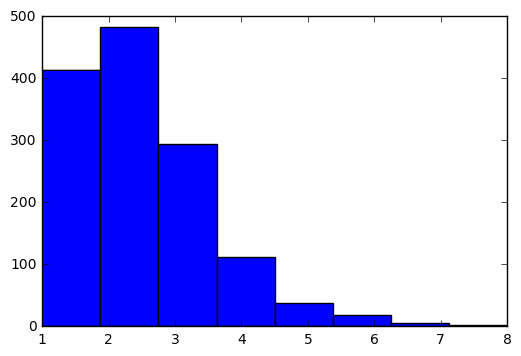

In [70]:
from nltk.corpus import treebank
from nltk.tree import Tree
from nltk.tree import ParentedTree
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np




# open questions:
# > should we only look for 'NP' or also for 'NP-SBJ' and so on?


# file ids of the treebank:
fileIds = treebank.fileids()

cutPointTestData = int(len(fileIds) * 0.9)

# list of all non-recursive sequences for NP:
nprhss = []
allrhss = []
lengths = []  
for fileId in fileIds[0:cutPointTestData]:
    
    tree = treebank.parsed_sents(fileId)[0]
    productions = tree.productions()
    
    for production in productions:
        
        lhs = production.lhs()
        rhs = production.rhs()

        if str(lhs).startswith('NP'):
        # if str(lhs).strip() == 'NP':
            # check if rhs is recursive (contains another NP):
            isRecursive = False
            for el in rhs:
                if str(el).startswith('NP'):
                # if str(el).strip() == 'NP':
                    isRecursive = True
            if  not isRecursive: 
                # only add non-recursive rhs:
                nprhss.append(str(rhs))
                # save rhs lengths for histogram:
                lengths.append(len(rhs))
        
        # add all rhs found to allrhss
        allrhss.append(str(rhs))

npGrammar = Counter(nprhss)
allGrammar = Counter(allrhss)

# create a probabilistic grammar (PCFG) based on relative frequency:
probNpGrammar = Counter()
for rule in npGrammar:
    probNpGrammar[rule] = npGrammar[rule]/len(nprhss)
    
# calculate conditional probabilities P(NP|sequence):
# for any sequence that is a NP at least one:
# (number of times this sequence was a NP) / (number of times this sequence occurred)
probNpGivenSequence = Counter()
for rule in npGrammar:
    # also count the length of the NP-sequences
    probNpGivenSequence[rule] = npGrammar[rule] / allGrammar[rule]

print('Most common NP-sequences:\n')
print(npGrammar.most_common(10))

shortestNpSeq = np.min(lengths)
longestNpSeq = np.max(lengths)
print('\n\n\nHistogram of NP-sequence lengths')
plt.hist(lengths, (longestNpSeq - shortestNpSeq + 1))
plt.show()


In [87]:
npProbThreshold = 0.5

TP = 0
FP = 0
TN = 0
FN = 0

for fileId in fileIds[cutPointTestData:-1]:
    
    thisFileLabels = []
    thisFileActualClass = []
    
    tree = treebank.parsed_sents(fileId)[0]
    ptree = ParentedTree.fromstring(str(tree))
    leaves = ptree.leaves()
    
    poss = []
    for leaf in leaves:
        leafIndex = leaves.index(leaf)
        treeLocation = ptree.leaf_treeposition(leafIndex)
        leaveParent = str(ptree[treeLocation[:-1]]).split(" ")
        pos = leaveParent[0][1:]
        poss.append(pos)

    startPos = 0  
    while startPos < len(poss):
        longestNpLength = 0
        longestNp = None
        for endPos in range(startPos, len(poss)):
            if (endPos - startPos + 1) > longestNpSeq:
                break
            sequence = '(' + poss[startPos]
            if startPos == endPos:
                sequence = sequence + ','
            else:
                for seqPos in range(startPos+1, endPos +1):
                    sequence = sequence + ', ' + poss[seqPos]
            sequence = sequence + ')'
            probIsNp = probNpGivenSequence[sequence]
            if probIsNp >= npProbThreshold:
                longestNpLength = endPos - startPos
                longestNp = sequence
                longestNpLeaves = leaves[startPos:endPos+1]
                longesNpProb = probNpGivenSequence[sequence]
      
        for i in range(0, longestNpLength + 1):
            
            # get the actual class of each word (NP or non-NP):
            leaf = leaves[startPos+i]
            leafIndex = leaves.index(leaf)
            treeLocation = ptree.leaf_treeposition(leafIndex)
            leaveParent = str(ptree[treeLocation[:-2]]).split(" ")
            pos = str(leaveParent[0][1:]).strip()
            if str(pos).startswith('NP'):
                thisFileActualClass.append(1)
            else:
                thisFileActualClass.append(0)
            
            # save the classified labels for evaluation
            if longestNp == None:
                thisFileLabels.append(0)
            else:
                thisFileLabels.append(1)
        
        startPos = startPos + longestNpLength
        startPos = startPos + 1
                
    for i in range(0, len(thisFileLabels)) :
        if thisFileLabels[i] == 1:
            if thisFileActualClass[i] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if thisFileActualClass[i] == 0:
                TN += 1
            else:
                FN += 1

            
print('TP: ' + str(TP))
print('FP: ' + str(FP))
print('TN: ' + str(TN))
print('FN: ' + str(FN))

acc = (TP + TN) / (TP + FP + TN + FN)
TPR = (TP) / (TP + FN)

print()
print('TPR: ' + str(TPR))
print('Accuracy: ' + str(acc))

TP: 328
FP: 36
TN: 159
FN: 49

TPR: 0.870026525198939
Accuracy: 0.8513986013986014
